In [26]:
import pandas as pd
import time
import random
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
# Specific tf libraries
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
# BOOST
import xgboost
import lightgbm


In [6]:
pd.options.mode.chained_assignment = None

In [7]:
%run ../common_utils.py

## 1 - BAGGING
Use the average of the predictions over the models, instead of using just one.
- Stacking! Wohoo. Probably smart to have a deep learning model in the stack.

In [ ]:
# All their kaggle scores
d = {'LaureRF': 0.20015,
     'Deep': 0.23278,
     'GB': 0.19968,
     'CB1': 0.23450,
     'XGB1': 0.23787,
     'KNN1' : 0.35042}

acc = pd.DataFrame(
    d,
    index=[0]
)
acc = acc.T
acc.columns = ['RMSLE']
acc

In [ ]:
LaureRF = pd.read_csv("ensemble_predictions/LaureRF.csv")
Deep = pd.read_csv("ensemble_predictions/Deep.csv")
GB = pd.read_csv("ensemble_predictions/GB.csv")
CB1 = pd.read_csv("ensemble_predictions/CB1.csv")
XGB1 = pd.read_csv("ensemble_predictions/XGB1.csv")
KNN1 = pd.read_csv("ensemble_predictions/KNN1.csv")

In [ ]:
LaureRF = LaureRF.sort_values(by="id")
Deep = Deep.sort_values(by="id")
GB = GB.sort_values(by="id")
CB1 = CB1.sort_values(by="id")
XGB1 = XGB1.sort_values(by="id")
KNN1 = KNN1.sort_values(by="id")

In [ ]:
LaureRF_prediction = LaureRF["price_prediction"].to_numpy().T
Deep_prediction = Deep["price_prediction"].to_numpy().T
GB_prediction = GB["price_prediction"].to_numpy().T
CB1_prediction = CB1["price_prediction"].to_numpy().T
XGB1_prediction = XGB1["price_prediction"].to_numpy().T
KNN1_prediction = KNN1["price_prediction"].to_numpy().T

In [ ]:
avg_prediction = np.average(
    [LaureRF_prediction,
     Deep_prediction,
     GB_prediction,
     CB1_prediction,
     XGB1_prediction,
     KNN1_prediction
    ],
    weights = 1 / acc['RMSLE'] ** 4,
    axis=0
)

In [ ]:
result = avg_prediction
submission = pd.DataFrame()
submission['id'] = LaureRF['id']
submission['price_prediction'] = result
if len(submission['id']) != 9937:
    raise Exception("Not enough rows submitted!")
submission.to_csv('BESTSUBMISSIONEVER', index=False)

## 2 - Stacking 🗼🗼
The more sofisticated way of ensemble the models.
Analogy: A king listening to advisors, and using their advise to make desicions.

In [8]:
%run ../common_utils.py

In [9]:
train, test, metaData = load_all_data()

### Deep learning advisor 🙌👍👍

In [93]:
# Mostly the ones correlated to price.
features =           ["building_id",
                      "area_total", "area_kitchen", "area_living", "floor", "stories", "rooms", "bathrooms_shared", "balconies", "latitude", "longitude", "constructed", # Numerical
                    "district", "material", "parking"] 

numerical_features = ["area_total", "area_kitchen", "area_living",
                      "floor", "stories", "rooms", "bathrooms_shared", "balconies", "latitude", "longitude", "constructed"]

cat_features = ["district", "material", "parking"]

droptable = ['longitude', 'latitude', 'area_kitchen', 'area_living', 'floor', 'stories'] # Not dropping theta!

train_labels, train_targets, test_labels = pre_process_numerical(
    features, numerical_features, train, test, outliers_value=7, val_data=False, val_split=0.1, random_state=42, scaler="minMax",
    add_R="True", add_rel_height="True",  add_spacious=True, droptable=droptable,
    one_hot_encode=True, cat_features=cat_features, drop_old=True)

Hot encoding
minMax


In [94]:
model_params = ([18, 12, 6], tf.nn.relu,
                     [False, False, False], 0.2, 'adam',
                      rmsle_custom, ['mse', 'msle', tf.keras.metrics.Accuracy()], True)

In [95]:
# NB! We cannot just compile ann model beforehand, will just keep training on same model.
ann_oof_train, ann_oof_test, hists = get_oof_ann(model_params, train_labels, train_targets, test_labels)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [96]:
# ADVISOR PERFORMANCE
for histories in hists:
    hist = pd.DataFrame(histories.history)
    hist['epoch'] = histories.epoch
    print(hist["val_loss"].tail(1))

399    0.225414
Name: val_loss, dtype: float64
399    0.228164
Name: val_loss, dtype: float64
399    0.215861
Name: val_loss, dtype: float64
399    0.217876
Name: val_loss, dtype: float64
399    0.255189
Name: val_loss, dtype: float64


In [97]:
print(np.sum(ann_oof_train >= 0))
print(np.sum(ann_oof_test >= 0))

23224
9937


### XGBoost advisor 😎😎

In [14]:
# ALL, and building ID!
features =           ["building_id", # For grouping
                      "area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", "seller", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute"] # Bool
                     #"street", "address"] #String

numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"]

droptable = ['longitude', 'latitude']

train_labels, train_targets, test_labels = pre_process_numerical(features, numerical_features, train, test,
                    outliers_value=7, val_data=False, val_split=0.1, random_state=42, scaler="minMax",
                    add_R=True, add_rel_height=True, add_spacious=True, droptable=droptable,
                    one_hot_encode=False, cat_features=cat_features, drop_old=True) # FALSE!

xgb_model = xgboost.XGBRegressor(max_depth=5, min_child_weight=12, gamma=0.15, subsample=0.8, colsample_bytree=0.8, reg_alpha=1.1, reg_lambda=0.3, learning_rate=0.01, n_estimators=10000)

minMax


In [15]:
xgb_oof_train, xgb_oof_test, scores = get_oof_xgboost(xgb_model, train_labels, np.log(train_targets), test_labels)

In [16]:
print(scores)

[0.20997854778572503, 0.20411401428401665, 0.1810377837518819, 0.20409205016570606, 0.23974537130488005]


### lgbm advisor 🤢🤢

In [17]:
features = ['building_id', # Metadata
            'area_total', 'area_kitchen', 'area_living', 'floor','constructed', 'stories', 'rooms', 'ceiling', 'bathrooms_shared', 'bathrooms_private','balconies', 'loggias', 'phones',
            'latitude', 'longitude', # Numerical
            'district', # Categorical, but not one-hot encoded
            #'street','address', # String - removed for now
            'elevator_without', 'elevator_passenger', 'elevator_service', 'garbage_chute', 'windows_court', 'windows_street','new',  # Bool
            'seller', 'layout', 'condition', 'material', 'parking', 'heating' # Categorical, one-hot encoded
            ]
numerical_features = ['area_total', 'area_kitchen', 'area_living', 'floor',
                      'constructed', 'stories', 'rooms', 'ceiling', 'bathrooms_shared', 'bathrooms_private','balconies', 'loggias', 'phones',
                    'latitude', 'longitude']

cat_features = ['seller', 'layout', 'condition', 'material', 'parking', 'heating' ]

droptable = []

train_labels, train_targets, test_labels = pre_process_numerical(features, numerical_features, train, test,
                    outliers_value=7, val_data=False, val_split=0.1, random_state=42, scaler="minMax",
                    add_R=True, add_rel_height=True, add_spacious=True, droptable=droptable,
                    one_hot_encode=True, cat_features=cat_features, drop_old=True) # FALSE!

Hot encoding
minMax


In [18]:
lgbm_model = lightgbm.LGBMRegressor(random_state=33, n_estimators=10000, verbose=-1)

In [19]:
lgbm_oof_train, lgbm_oof_test, scores = get_oof_lgbm(lgbm_model, train_labels, np.log(train_targets), test_labels)

c:\python\python38\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[129]	valid_0's l2: 0.0427566	valid_0's custom_asymmetric_eval: 0.011561
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[209]	valid_0's l2: 0.0410791	valid_0's custom_asymmetric_eval: 0.0113785
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[351]	valid_0's l2: 0.0318635	valid_0's custom_asymmetric_eval: 0.00994637
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[228]	valid_0's l2: 0.0425138	valid_0's custom_asymmetric_eval: 0.0113091
Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[171]	valid_0's l2: 0.0535613	valid_0's custom_asymmetric_eval: 0.0130623


In [20]:
# Advisor performance
print(scores)

[0.20677656860314403, 0.2026798412093652, 0.17850361411400356, 0.20618871199762442, 0.23143316021102583]


## Make an xgb king, to listen to his advisors 🎩

For now, just a copy of XGBoost advisor...

In [190]:
# ALL, and building ID!
features =           ["building_id", # For grouping
                      "area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", "seller", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute"] # Bool
                     #"street", "address"] #String

numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"]

droptable = ['longitude', 'latitude']

train_labels, train_targets, test_labels = pre_process_numerical(features, numerical_features, train, test,
                    outliers_value=7, val_data=False, val_split=0.1, random_state=42, scaler="minMax",
                    add_R=True, add_rel_height=True, add_spacious=True, droptable=droptable,
                    one_hot_encode=True, cat_features=cat_features, drop_old=True) 

Hot encoding
minMax


In [191]:
xgb_king = xgboost.XGBRegressor(max_depth=5, min_child_weight=12, gamma=0.15, subsample=0.8, colsample_bytree=0.8, reg_alpha=1.1, reg_lambda=0.3, learning_rate=0.01, n_estimators=10000)

In [192]:
# TODO: shouldn't xgb and lgbm predict the log(price)?
# NB! ann predicts some negative values! Maybe RELU on the output?
train_labels["xgb_preds"] = xgb_oof_train
train_labels["lgbm_preds"] = lgbm_oof_train
train_labels["ann_preds"] = np.log(ann_oof_train)

test_labels["xgb_preds"] = lgbm_oof_test
test_labels["lgbm_preds"] = xgb_oof_test
test_labels["ann_preds"] = np.log(ann_oof_test)

In [195]:
scores, avg, best_model, best_index = XGB_groupKFold(5, xgb_king, train_labels, np.log(train_targets),
    eval_metric='rmse')

In [196]:
# Kings performance
print(scores)
print("==>", np.average(scores))

[0.2144216063233119, 0.20998552806095488, 0.18521362549580703, 0.2163643628806314, 0.245536358685053]
==> 0.21430429628915165


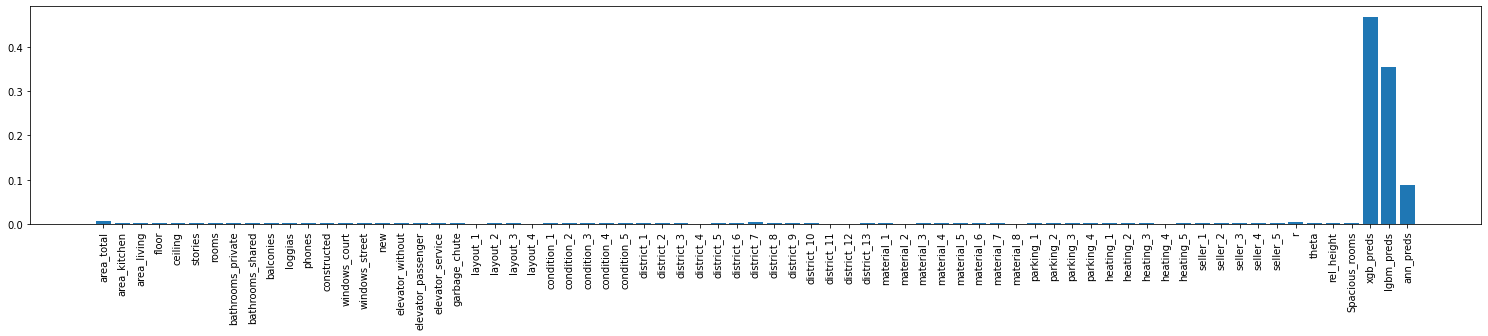

In [197]:
plt.figure(figsize=(26, 4))
plt.bar(train_labels.drop(["building_id"], axis=1).columns.tolist(), xgb_king.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [199]:
# king_prediction_1 uses ann, xgboost and lgboost advisors.
predict_and_store(best_model, test_labels.drop(["building_id"], axis=1), test, path="ensemble_predictions/simple_stack_prediction_1", exponential=True)

### Add more advisors - RF 🌲🌲🎄🎄
https://stackoverflow.com/questions/8961586/do-i-need-to-normalize-or-scale-data-for-randomforest-r-package

In [21]:
features = ["building_id",
            "area_total", "latitude", "longitude", "floor", "stories", # Numerical
            "district", 'condition' # Categorical
           ]

numerical = [] # No need to scale for RF! https://stackoverflow.com/questions/8961586/do-i-need-to-normalize-or-scale-data-for-randomforest-r-package
cat_features = []
droptable = []

train_labels, train_targets, test_labels = pre_process_numerical(features, numerical_features, train, test,
                    outliers_value=7, val_data=False, val_split=0.1, random_state=42, scaler="none",
                    add_R=False, add_rel_height=False, add_spacious=False, droptable=droptable,
                    one_hot_encode=False, cat_features=cat_features, drop_old=False) 

Hot encoding


In [40]:
rf_oof_train, rf_oof_test, scores = get_oof_rf(train_labels, train_targets, test_labels) # Use log() for RF?

In [41]:
print(scores)
print("==>\t",np.average(scores))

[0.2250231175181627, 0.2600617011097793, 0.22247704249671482, 0.2346608919885963, 0.30057918476059436]
==>	 0.2485603875747695


### KNN Advisor 🏡🕺👨‍👨‍👧👮‍♂️🏠🏠🕺🏡👨‍🔧🏠👫🕺

In [51]:
features = ["building_id", # For Grouping
            "area_total", "ceiling", "floor", "bathrooms_shared", "balconies", "stories", "rooms","latitude","longitude", # Numerical
            "windows_street", "elevator_without", # Bool
            "parking", "heating", "district", "condition"  # Categorical
           ]

numerical_features = ["area_total", "ceiling", "floor", "bathrooms_shared", "balconies", "stories", "rooms"]
categorical_features = ["parking", "heating", "district", "condition"]
droptable=["latitude","longitude"]

train_labels, train_targets, test_labels = pre_process_numerical(features, numerical_features, train, test,
                    outliers_value=7, val_data=False, val_split=0.1, random_state=42, scaler="minMax",
                    add_R=True, add_rel_height=True, add_spacious=True, droptable=droptable,
                    one_hot_encode=True, cat_features=cat_features, drop_old=False) 

Hot encoding
minMax


In [52]:
knn_oof_train, knn_oof_test, scores = get_oof_knn(train_labels, train_targets, test_labels)

c:\python\python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
c:\python\python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
c:\python\python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
c:\python\python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
c:\python\python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
c:\python\python38\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature name

In [53]:
print(scores)
print("==>\t", np.average(scores))

[0.4649333641263027, 0.39575516978262326, 0.39627134014461696, 0.4560931386015719, 0.4905647799132056]
==>	 0.4407235585136641


### AGAIN - the XGB King! 🎩🎩

In [57]:
# ALL, and building ID!
features =           ["building_id", # For grouping
                      "area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", "seller", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute"] # Bool
                     #"street", "address"] #String

numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"]

droptable = ['longitude', 'latitude']

train_labels, train_targets, test_labels = pre_process_numerical(features, numerical_features, train, test,
                    outliers_value=7, val_data=False, val_split=0.1, random_state=42, scaler="minMax",
                    add_R=True, add_rel_height=True, add_spacious=True, droptable=droptable,
                    one_hot_encode=True, cat_features=cat_features, drop_old=True) 

Hot encoding
minMax


In [58]:
xgb_king = xgboost.XGBRegressor(max_depth=5, min_child_weight=12, gamma=0.15, subsample=0.8, colsample_bytree=0.8, reg_alpha=1.1, reg_lambda=0.3, learning_rate=0.01, n_estimators=10000)

In [72]:
# TODO: shouldn't xgb and lgbm predict the log(price)?
# NB! ann predicts some negative values! Maybe RELU on the output?
train_labels["xgb_preds"] = xgb_oof_train
train_labels["lgbm_preds"] = lgbm_oof_train
train_labels["ann_preds"] = np.log(ann_oof_train)
train_labels["knn_preds"] = np.log(knn_oof_train)
train_labels["rf_preds"] = np.log(rf_oof_train)

test_labels["xgb_preds"] = lgbm_oof_test
test_labels["lgbm_preds"] = xgb_oof_test
test_labels["ann_preds"] = np.log(ann_oof_test)
test_labels["knn_preds"] = np.log(knn_oof_test)
test_labels["rf_preds"] = np.log(rf_oof_test)

In [73]:
scores, avg, best_model, best_index = XGB_groupKFold(5, xgb_king, train_labels, np.log(train_targets),
    eval_metric='rmse')

In [74]:
# Kings performance
print(scores)
print("==>", np.average(scores))

[0.2160467549902171, 0.2117549064318086, 0.1864839516103819, 0.22100003805854376, 0.24678393305671234]
==> 0.21641391682953276


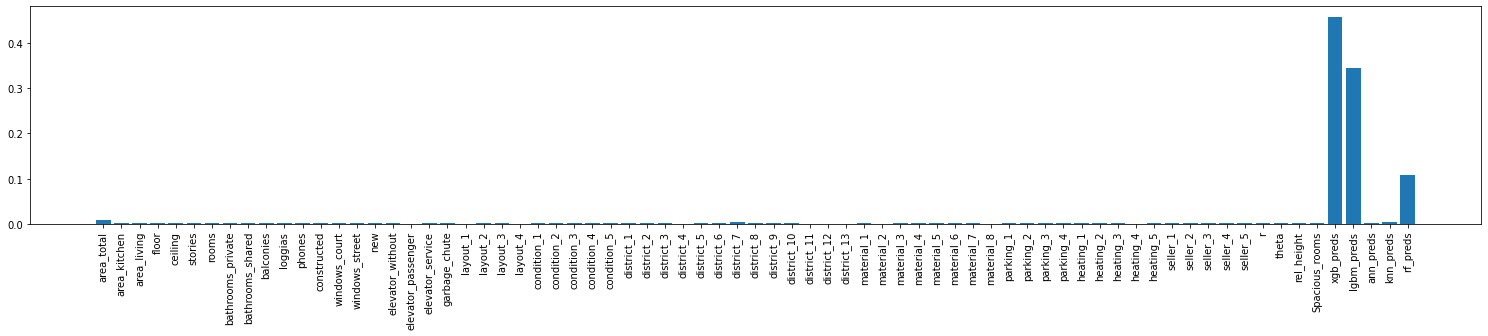

In [75]:
plt.figure(figsize=(26, 4))
plt.bar(train_labels.drop(["building_id"], axis=1).columns.tolist(), xgb_king.feature_importances_)
plt.xticks(rotation=90)
plt.show()

### What about an ANN king? 🎩🎩

In [190]:
%run ../common_utils.py

In [191]:
# Mostly the ones correlated to price.
features =           ["building_id",
                      "area_total", "area_kitchen", "area_living", "floor", "stories", "rooms", "bathrooms_shared", "balconies", "latitude", "longitude", "constructed", # Numerical
                    "district", "material", "parking"] 

numerical_features = ["area_total", "area_kitchen", "area_living",
                      "floor", "stories", "rooms", "bathrooms_shared", "balconies", "latitude", "longitude", "constructed"]

cat_features = ["district", "material", "parking"]

droptable = ['longitude', 'latitude', 'area_kitchen', 'area_living', 'floor', 'stories'] # Not dropping theta!

train_labels, train_targets, test_labels = pre_process_numerical(
    features, numerical_features, train, test, outliers_value=7, val_data=False, val_split=0.1, random_state=42, scaler="minMax",
    add_R="True", add_rel_height="True",  add_spacious=True, droptable=droptable,
    one_hot_encode=True, cat_features=cat_features, drop_old=True)

Hot encoding
minMax


In [192]:
train_labels["xgb_preds"] = np.exp(xgb_oof_train)
train_labels["lgbm_preds"] = np.exp(lgbm_oof_train)
train_labels["ann_preds"] = ann_oof_train
train_labels["knn_preds"] = knn_oof_train
train_labels["rf_preds"] = rf_oof_train

test_labels["xgb_preds"] = np.exp(lgbm_oof_test)
test_labels["lgbm_preds"] = np.exp(xgb_oof_test)
test_labels["ann_preds"] = ann_oof_test
test_labels["knn_preds"] = knn_oof_test
test_labels["rf_preds"] = rf_oof_test

In [171]:
train_labels.drop(train_labels.columns.to_list()[1:-5], inplace=True, axis=1)
test_labels.drop(test_labels.columns.to_list()[1:-5], inplace=True, axis=1)

In [173]:
## TODO! Use a deeper net, with regularization maybe :D
model_params = ([18, 18, 18], tf.nn.leaky_relu,
                     [False, False, False], 0.2, 'adam',
                      rmsle_custom, ['mse', 'msle', tf.keras.metrics.Accuracy()], True)

In [174]:
ann_scores, models, best_model, hists = ANN_groupKFold(5, model_params, train_labels, train_targets)


....................................................................Epoch 00068: early stopping
New best model!

.........................................Epoch 00041: early stopping

...............................................................Epoch 00063: early stopping
New best model!

.................................................................Epoch 00065: early stopping

....................................................................................................
.......................Epoch 00123: early stopping


In [175]:
print(ann_scores)
print("==>\t", np.average(ann_scores))

[0.1845317929983139, 16.416553497314453, 0.15477019548416138, 0.17252406477928162, 0.19396379590034485]
==>	 3.424468669295311


In [181]:
# Results
history = hists[2]
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
#hist.loc[hist["val_loss"]==hist["val_loss"].min()]
hist.tail(5)

,loss,mse,msle,accuracy,val_loss,val_mse,val_msle,val_accuracy,epoch
58,0.199756,1.819740e+14,0.042339,0.0,0.154687,1.403201e+14,0.032376,0.0,58
59,0.199792,1.815726e+14,0.042152,0.0,0.154832,1.359596e+14,0.032233,0.0,59
60,0.200065,1.824572e+14,0.042399,0.0,0.153562,1.366084e+14,0.032000,0.0,60
61,0.199676,1.814461e+14,0.042116,0.0,0.153710,1.369119e+14,0.031852,0.0,61
62,0.199612,1.827060e+14,0.042139,0.0,0.154770,1.390247e+14,0.032644,0.0,62


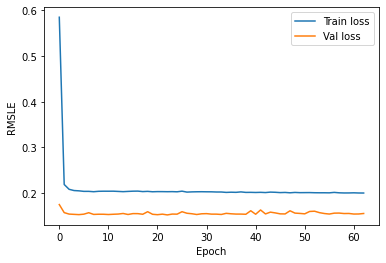

In [183]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('RMSLE')
#plt.yscale("log")
plt.plot(hist['epoch'], hist['loss'], label='Train loss')
plt.plot(hist['epoch'], hist['val_loss'], label = 'Val loss')
plt.legend()
plt.show()

In [184]:
# deep_king_1: uses same features as deep advisor, and same model type as 8_4.
# deep_king_2: is the same, just re-running deep_advisor for better score. NB: deleted...
# deep_king_3: Is deeper, and wider, and adds regularizations. Is worse. - NB! Also used leaky relu! Three tings were added: depth, regularization and leaky => worse!
# deep_king_4: removes regularization, is a little less wide (64)        - NB! Also used leaky relu! Regularization was removed: improved slightly!
# deep_king_5: removes all other than the pre-trained ones!              - Completely different test. Made a lot of copies.

In [193]:
predict_and_store(models[4], # best_model,
                  test_labels.drop(["building_id"], axis=1), test, path="ensemble_predictions/deep_king_5_4", exponential=False)

ValueError: in user code:

    c:\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    c:\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\python\python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\python\python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\python\python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    c:\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    c:\python\python38\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    c:\python\python38\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_65 is incompatible with the layer: expected axis -1 of input shape to have value 5 but received input with shape (None, 39)
